In [1]:
from arguments import ModelParams, ArgumentParser
from depth_images import calibrate_depth
from gaussian_renderer import GaussianModel
from scene import Scene
import matplotlib.pyplot as plt

parser = ArgumentParser()
dataset = ModelParams(parser)
dataset.model_path = ""
dataset.source_path = "../data/redwood_proc/00002/"
dataset.images = "images"
dataset.resolution = -1
dataset.white_background = False
dataset.eval=True
dataset.num_train_images = 5
gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians,shuffle=False)

calibrate_depth(scene)

Reading camera 192/192
Converting point3d.bin to .ply, will happen only the first time you open the scene.
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  21080
2.8333694198734545 -0.34728153186521565


In [2]:
# from utils.graphics_utils import geom_transform_points
# import torch

# all_colmap_depths = []
# all_image_depths = []
# for train_camera in scene.getTrainCameras():
#     points = torch.tensor(scene.point_cloud.points,device=train_camera.camera_center.device)
#     valid_points = torch.tensor([train_camera.colmap_id in s for s in scene.point_cloud.visible_in_cameras],device=points.device)
#     points = points[valid_points]

#     depths = torch.sum((points - train_camera.camera_center)**2,dim=1)**0.5
#     trans = geom_transform_points(points,train_camera.full_proj_transform)
#     trans[:]+=1
#     trans[:,0] *= train_camera.image_width/2
#     trans[:,1] *= train_camera.image_height/2

#     sample_x = trans[:,0].round().long()
#     sample_y = trans[:,1].round().long()

#     val = (sample_x>=0) & (sample_x<train_camera.image_width) & (sample_y>=0) & (sample_y<train_camera.image_height)

#     image_depths = torch.zeros_like(depths)
#     image_depths[val] = train_camera.depth.cuda()[0,sample_y[val],sample_x[val]]

#     all_colmap_depths.append(depths[image_depths>0])
#     all_image_depths.append(image_depths[image_depths>0])

In [3]:
# import numpy as np
# all_image_depths = torch.cat(all_image_depths).cpu()
# all_colmap_depths = torch.cat(all_colmap_depths).cpu()
# alpha,beta = np.polyfit(all_image_depths,all_colmap_depths, 1)
# print(alpha,beta)
# #train_camera.depth = train_camera.depth*alpha+beta

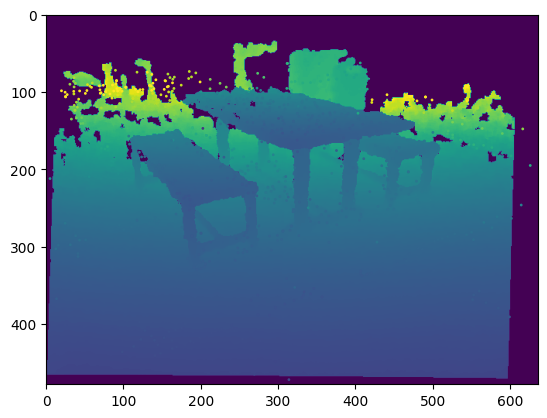

In [5]:
from utils.graphics_utils import geom_transform_points
import torch

train_camera = scene.getTrainCameras()[0]
points = torch.tensor(scene.point_cloud.points,device=train_camera.camera_center.device)
valid_points = torch.tensor([train_camera.colmap_id in s for s in scene.point_cloud.visible_in_cameras],device=points.device)
points = points[valid_points]

depths = torch.sum((points - train_camera.camera_center)**2,dim=1)**0.5
trans = geom_transform_points(points,train_camera.full_proj_transform)
trans[:]+=1
trans[:,0] *= train_camera.image_width/2
trans[:,1] *= train_camera.image_height/2

plt.imshow(train_camera.depth[0],vmin=0,vmax=20)
#plt.show()
plt.scatter(trans[:,0].cpu().detach(),trans[:,1].cpu().detach(),s=1,c=depths.cpu().detach(),vmin=0,vmax=20)
plt.xlim([0,train_camera.image_width])
plt.ylim([0,train_camera.image_height])
plt.gca().invert_yaxis()
plt.show()
